In [1]:
pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

def make_sine_ts(n_points, dimension=1, n_periods=4, ampl=10):
    sigma = ampl / 10
    time = np.arange(1, n_points + 1)
    series_sine = ampl * np.sin(np.tile(time * (2 * np.pi * n_periods) / n_points, (dimension, 1)).T) + sigma * np.random.randn(n_points, dimension)
    table = np.column_stack((time, series_sine))
    columns = ['Time'] + [f'Sine_{i}' for i in range(1, dimension + 1)]
    ts = pd.DataFrame(table, columns=columns)
    return ts

In [17]:
# generate synthetic time series
ts1 = make_sine_ts(1000, 1)
ts2 = make_sine_ts(1000, 1, n_periods=2)
ts3 = make_sine_ts(1000, 1, n_periods=1)
ts = ts1
ts['Sine_2'] = ts2.iloc[:, 1]
ts['Sine_3'] = ts3.iloc[:, 1]
ts

,Time,Sine_1,Sine_2,Sine_3
0,1.0,1.022080,0.627813,-1.495356
1,2.0,-0.528390,-1.082066,-0.155791
2,3.0,1.024925,-0.686068,0.511766
3,4.0,1.344592,-0.436075,0.808502
4,5.0,2.202428,-0.400859,1.146847
...,...,...,...,...
995,996.0,-2.334123,-0.617350,1.063129
996,997.0,-2.460467,0.286179,1.171487
997,998.0,0.204014,0.509043,-0.352009
998,999.0,-0.227473,0.850925,0.944904


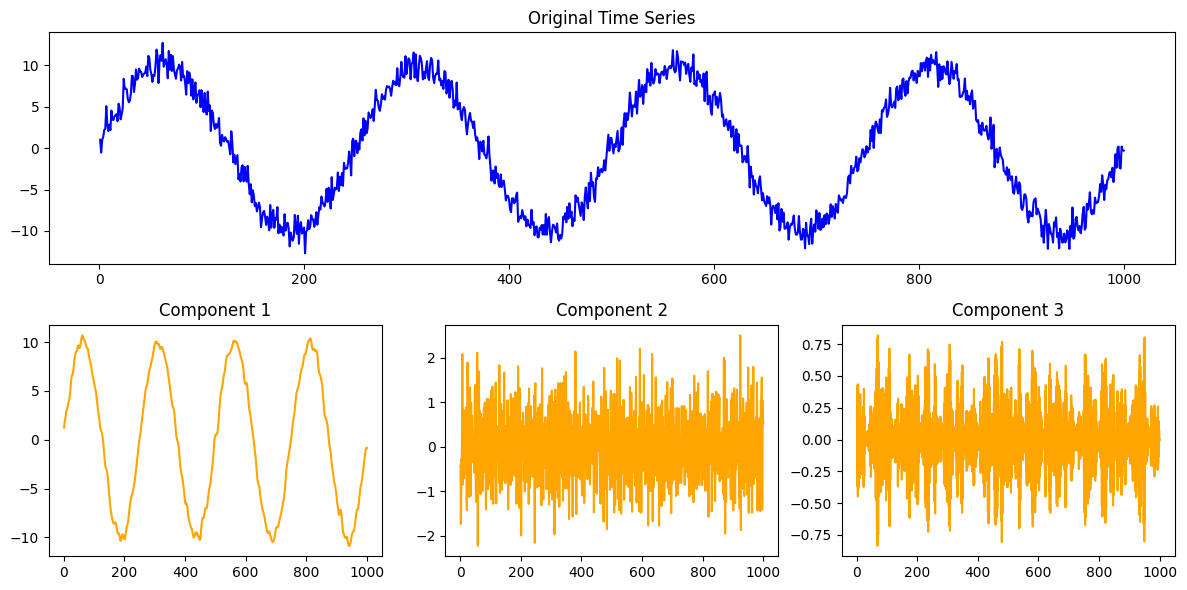

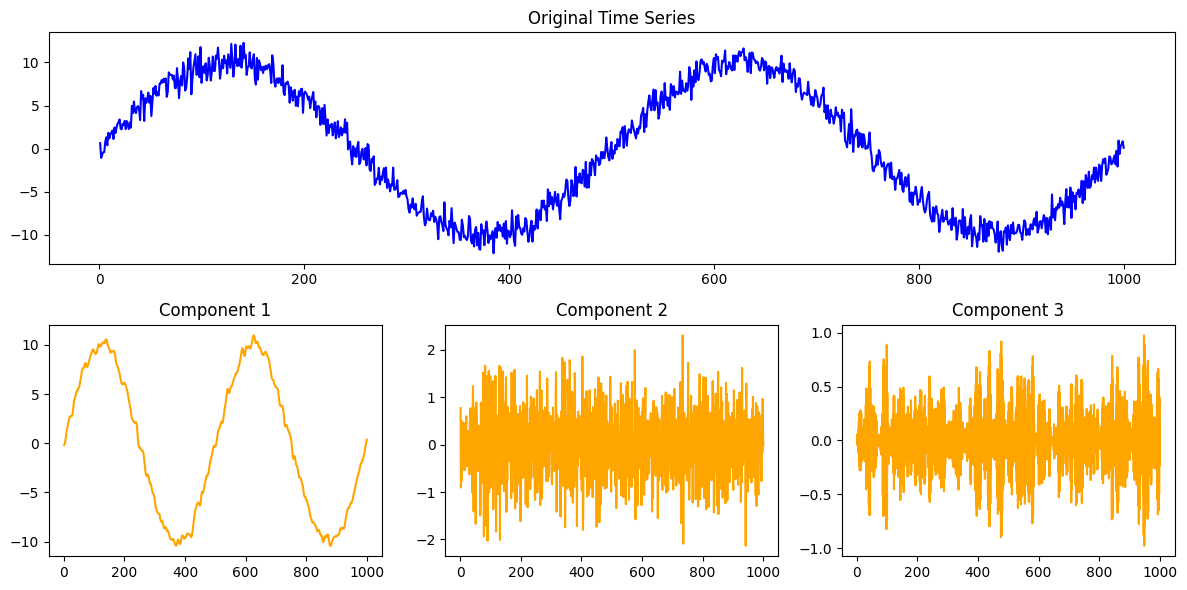

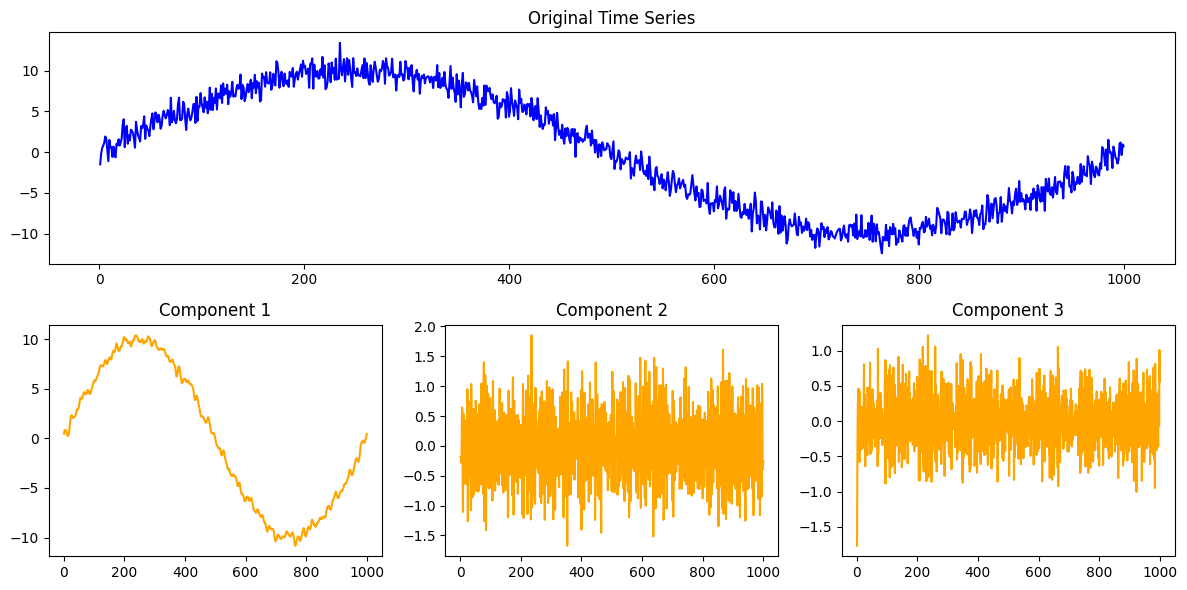

In [21]:
from pyts.decomposition import SingularSpectrumAnalysis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Extract the values from the DataFrame
time_series_values = ts.iloc[:, 1:].values.T  # Exclude the 'Time' column

# Singular Spectrum Analysis
window_size = 6  # Adjust as needed
ssa = SingularSpectrumAnalysis(window_size=window_size, groups="auto")
components = ssa.fit_transform(time_series_values)

for graph_idx in range(0, time_series_values.shape[0]):
  # Plot the original time series and its components
  plt.figure(figsize=(12, 6))

  # Plot original time series
  plt.subplot(2, 1, 1)
  plt.plot(ts['Time'], time_series_values[graph_idx], label='Original Time Series', color='blue')
  plt.title('Original Time Series')

  # Plot SSA components
  for i in range(components.shape[1]):
      plt.subplot(2, components.shape[1], components.shape[1] + i + 1)
      plt.plot(ts['Time'], components[graph_idx, i, :], label=f'Component {i+1}', color='orange')
      plt.title(f'Component {i+1}')

  plt.tight_layout()
  plt.show()

In [22]:
time_series_values.shape

(3, 1000)

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def forecast_ssa(series, window_size=5, groups="auto"):
    ssa = SingularSpectrumAnalysis(window_size=window_size, groups=groups)
    X_ssa = ssa.fit_transform(series.reshape(1, -1))

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_ssa[0].T[:-1], series[1:], test_size=0.2, shuffle=False)

    # Train a simple linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    y_pred = model.predict(X_ssa[0].T)

    # Plot the original series, true values, and predicted values
    plt.plot(series, label='Original Series')
    plt.plot(y_pred, label='Predicted Values', linestyle='dashed')
    plt.legend()
    plt.show()

Mean Squared Error: 0.6562574828684934


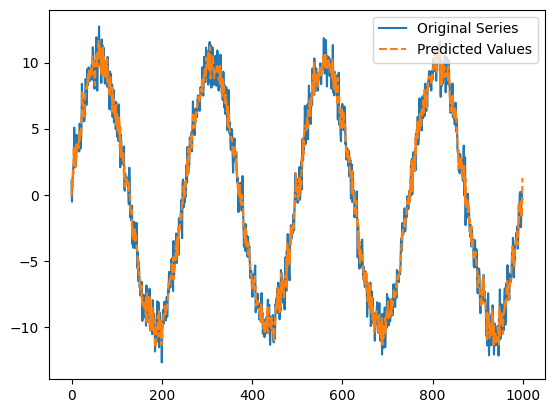

In [24]:
forecast_ssa(time_series_values[0], window_size=10, groups=5)

In [25]:
# !pip install git+https://github.com/AbdullahO/mSSA.git
!pip install git+https://github.com/kieferk/pymssa.git

  Cloning https://github.com/kieferk/pymssa.git to /tmp/pip-req-build-lwy6632j
  Running command git clone --filter=blob:none --quiet https://github.com/kieferk/pymssa.git /tmp/pip-req-build-lwy6632j
  Resolved https://github.com/kieferk/pymssa.git to commit 9d4d3e2c317ef64d0604796cf3fbdf9b5dc8e7fe
  Preparing metadata (setup.py) ... done


In [26]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import r2_score
from pymssa import MSSA

In [73]:
def forecast_mssa(ts, tp=400, window_size=60):
    ts_tr = ts.iloc[:-tp, 1:]  # Exclude the 'Time' column
    tr_means = np.nanmean(ts_tr, axis=0)
    ts_tr = ts_tr - tr_means

    ts_te = ts.iloc[-tp:, 1:] - tr_means # Exclude the 'Time' column

    mssa = MSSA(n_components='parallel_analysis',
            pa_percentile_threshold=95,
            window_size=window_size,
            verbose=True)
    mssa.fit(ts_tr)

    time_series_c = ts.iloc[:, 1:] - tr_means

    for ts_index in range(time_series_c.shape[1]):
        tr = np.zeros(time_series_c.shape[0])
        tr[:] = np.nan

        te = np.copy(tr)

        tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
        fc = mssa.forecast(tp, timeseries_indices=ts_index)

        ytrue = ts_te.iloc[:, ts_index].values
        yhat = fc.ravel()[~pd.isnull(ytrue)]
        ytrue = ytrue[~pd.isnull(ytrue)]

        r2 = r2_score(ytrue, yhat)
        mse = mean_squared_error(ytrue, yhat)
        te[-tp:] = fc

        fig, ax = plt.subplots(figsize=(18, 7))
        ax.plot(time_series_c.index, time_series_c.iloc[:, ts_index].values + tr_means[ts_index], lw=3, alpha=0.2, c='k', label=time_series_c.columns[ts_index])
        ax.plot(time_series_c.index, tr + tr_means[ts_index], lw=2, c='steelblue', alpha=0.75, label='Train')
        ax.plot(time_series_c.index, te + tr_means[ts_index], lw=2, c='darkgoldenrod', label='Forecast')
        # ax.set_xlabel("Time, h")
        # ax.set_ylabel("Energy Spot Price, EUR per MWh")
        ax.set_title('Forecast R2: {:.3f}, MSE: {:.3f}'.format(r2, mse))
        ax.legend()

        plt.show()

Constructing trajectory matrix
Trajectory matrix shape: (120, 541)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 4
Constructing components
Calculating optimal reconstruction orders


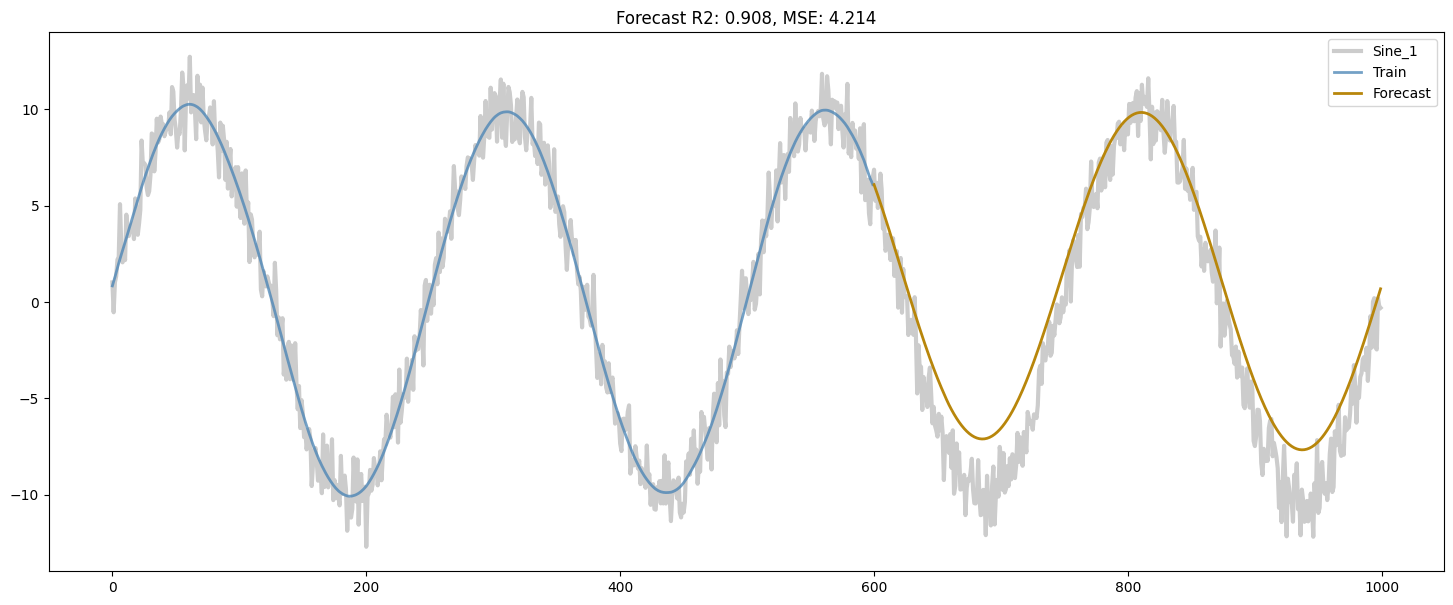

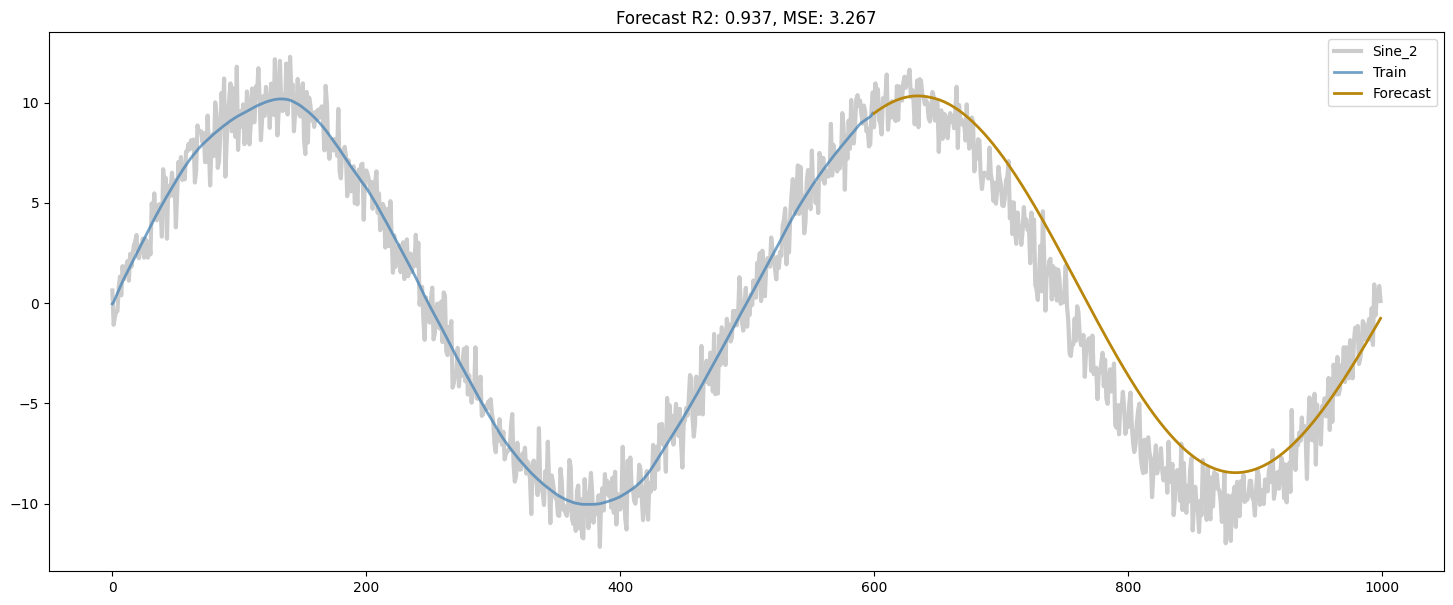

In [74]:
forecast_mssa(ts.iloc[:, [0, 1, 2]])

Constructing trajectory matrix
Trajectory matrix shape: (60, 541)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders


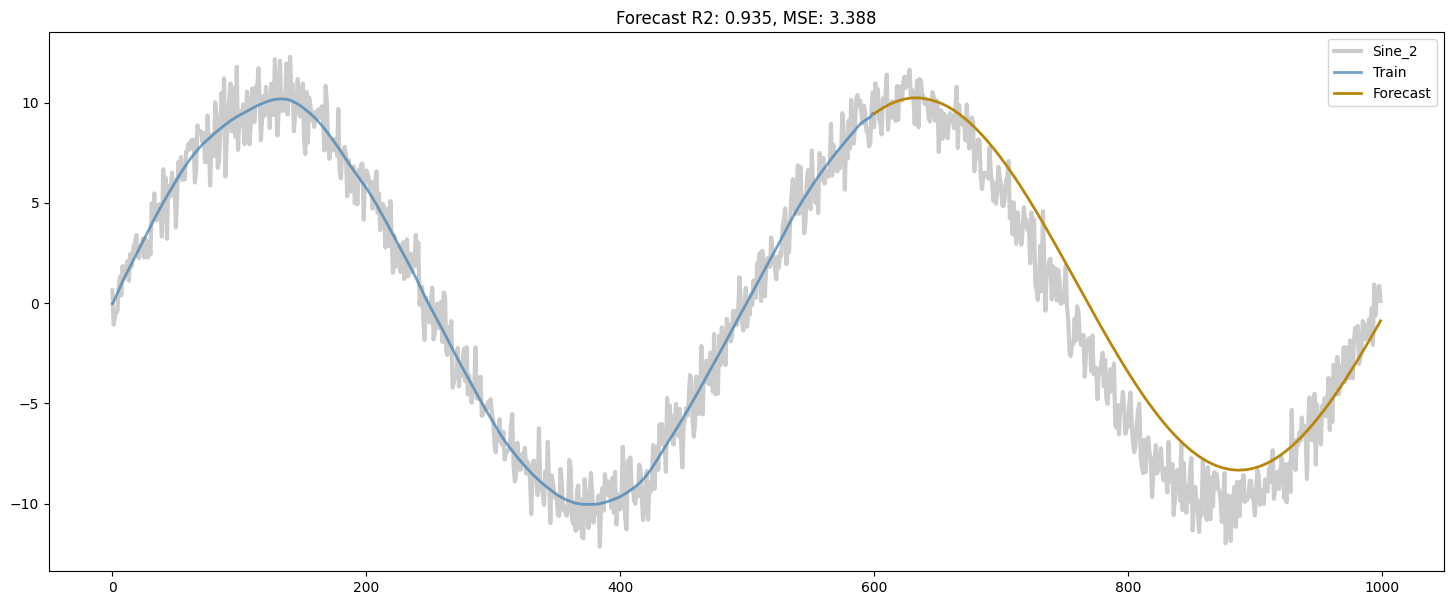

In [70]:
forecast_mssa(ts.iloc[:, [0, 2]])



---
Electricity spot dataset price hourly for the last years


In [14]:
electricity_ts = pd.read_csv("/content/Elspotprices.csv", delimiter=';', decimal=',')[:24*7][::-1]
electricity_ts = electricity_ts.reset_index(drop=True)
electricity_ts

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022-10-12 22:00,2022-10-13 00:00,DK2,1626.709961,218.660004
1,2022-10-12 23:00,2022-10-13 01:00,DK2,1562.290039,210.000000
2,2022-10-13 00:00,2022-10-13 02:00,DK2,1441.770020,193.800003
3,2022-10-13 01:00,2022-10-13 03:00,DK2,1361.119995,182.960007
4,2022-10-13 02:00,2022-10-13 04:00,DK2,1450.839966,195.020004
...,...,...,...,...,...
163,2022-10-19 17:00,2022-10-19 19:00,DK2,1688.050049,226.919998
164,2022-10-19 18:00,2022-10-19 20:00,DK2,1238.589966,166.500000
165,2022-10-19 19:00,2022-10-19 21:00,DK2,1090.329956,146.570007
166,2022-10-19 20:00,2022-10-19 22:00,DK2,1102.079956,148.149994


Constructing trajectory matrix
Trajectory matrix shape: (72, 73)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 5
Constructing components
Calculating optimal reconstruction orders


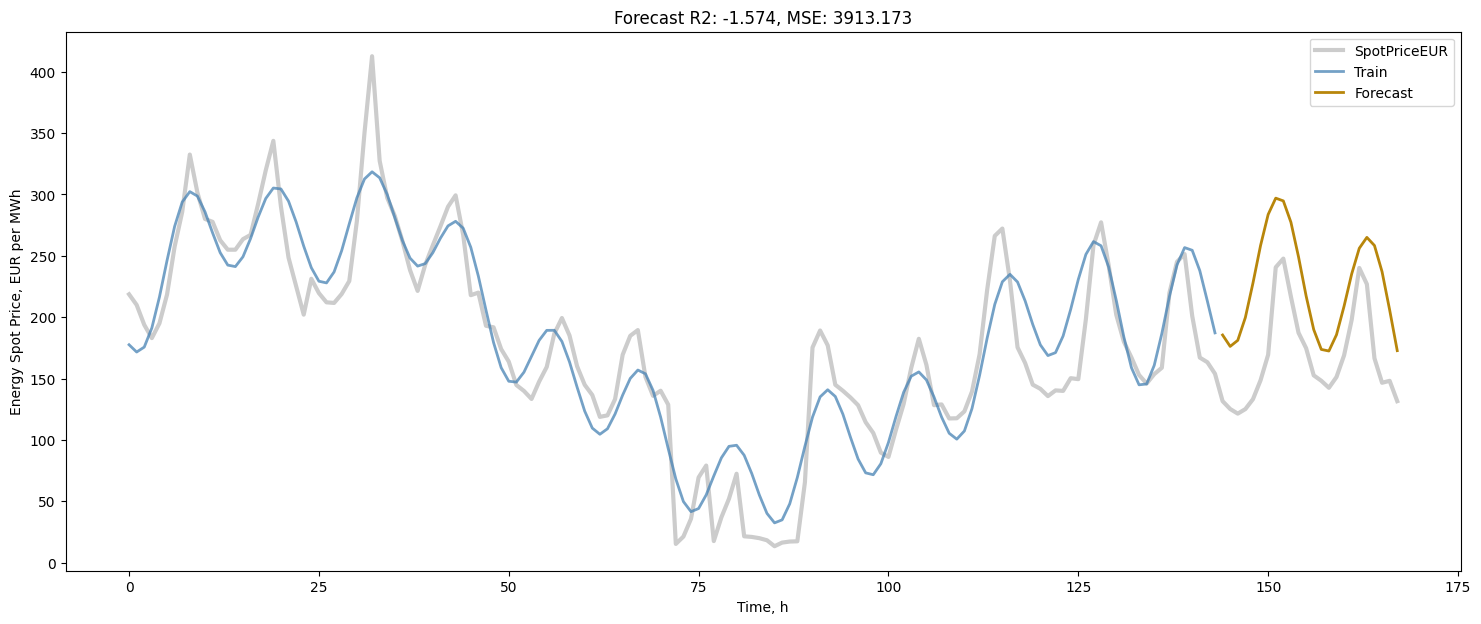

In [15]:
forecast_mssa(electricity_ts.iloc[:, [0, 4]], tp=24, window_size=24*3)

Forecast with new method (TODO: recovery to original space)

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import mean_squared_error
from scipy.linalg import hankel
from sklearn.covariance import LedoitWolf

In [58]:
time_series_data = ts.iloc[:, 1:]
time_series_data

,Sine_1,Sine_2,Sine_3,Sine_4,Sine_5
0,2.357211,-0.379313,-0.379006,1.406728,-0.634477
1,0.130353,0.782342,-0.148648,0.387824,2.056372
2,1.593099,1.878017,0.822308,1.277484,2.037180
3,0.736710,4.936264,2.818342,1.926283,3.119512
4,1.101280,2.164311,3.718801,3.040034,3.026901
...,...,...,...,...,...
495,-0.984877,-2.928232,-1.830071,-1.980378,-1.205748
496,-1.543319,-3.067007,-0.394950,0.013397,-3.329113
497,-0.646069,-0.354287,-2.196516,-2.520047,-1.129516
498,-0.268017,-0.509709,-1.582570,-0.660841,-0.132155


In [117]:
time_series_data.shape

(500, 5)

In [64]:
window_size

6

In [61]:
def create_hankel_matrix(time_series, window_size):
    hankel_matrix = hankel(time_series[:-window_size+1], time_series[-window_size:])
    return hankel_matrix

In [107]:
def calculate_distance_matrix(matrices):
    # Check if the matrices have the same number of vectors

    distances_matrix = np.zeros((matrices.shape[1], matrices.shape[0], matrices.shape[0]))

    # Iterate through the vectors in the matrices
    for i in range(matrices.shape[0]):
        for j in range(matrices.shape[0]):
            for t in range(matrices.shape[1]):
                distance = np.linalg.norm(matrices[i, t, :].T @ matrices[j, t, :])
                distances_matrix[t, i, j] = distance
    return distances_matrix

In [109]:
def reshape_to_2d(matrix):
    return matrix.reshape(matrix.shape[0], -1)

def reshape_to_3d(matrix, num):
    return matrix.reshape(matrix.shape[0], num, -1)

In [131]:
def get_distance_matrix(time_series, window_size=6):
    matrices = np.stack([create_hankel_matrix(time_series.iloc[:, i], window_size) for i in range(time_series.shape[1])])
    distances = calculate_distance_matrix(matrices)
    return distances

In [137]:
distances = get_distance_matrix(time_series_data)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(reshape_to_2d(distances[:-1]), reshape_to_2d(distances[1:]), test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

X_test.shape

Mean Squared Error: 671.9226253701147


(99, 25)

In [134]:
def predict(time_series, model):
    distances = get_distance_matrix(time_series)

    X_dist = reshape_to_2d(distances)

    y_dist = reshape_to_3d(model.predict(X_dist), distances.shape[1])

    y_pred = decoder(y_dist)

    return y_pred